# Intro to RL: Gymnasium, DQN, Actor-critic

## Part #1: OpenAI Gym / Farama Foundation Gymnasium

[Gym](https://gym.openai.com) — это набор инструментов для разработки и сравнения алгоритмов обучения с подкреплением, который также включает в себя большой [набор окружений](https://gym.openai.com/envs/).

[Gymnasium](https://gymnasium.farama.org/) — актуальный форк Gym'а. Имеет смысл по возможности использовать его. Но, т.к. большинство гайдов написаны под старую (pre- 0.21) версию Gym'а, то будьте готовы к [некоторым правкам кода](https://gymnasium.farama.org/content/migration-guide/). К счастью, большинство современных библиотек активно переходят или уже перешли и на Gymnasium, и на новый интерфейс.

In [1]:
# Похожий код вы наверняка уже встречали — ставим нужные зависимости, если это колаб
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3



![Mountain Car](https://gymnasium.farama.org/_images/mountain_car.gif)

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(3)


# Создаем окружение
env = gym.make("MountainCar-v0")

# Инициализируем окружение
state, info = env.reset()
print(f"state: {state}")

# Выполняем действие в среде 
next_state, r, terminated, truncated, info = env.step(0)
print(f'{next_state=} | {r=} | {terminated=} | {truncated=} | {info=}')

# Закрываем окружение
env.close()

state: [-0.513  0.   ]
next_state=array([-0.515, -0.001], dtype=float32) | r=-1.0 | terminated=False | truncated=False | info={}


### Основные методы окружения:

- `reset()` — инициализация окружения, возвращает первое наблюдение (состояние) и доп информацию.  
- `step(a)` — выполнить в среде действие $\mathbf{a}$ и получить кортеж: $\mathbf{\langle s_{t+1}, r_t, terminated, truncated, info \rangle}$, где $\mathbf{s_{t+1}}$ - следующее состояние, $\mathbf{r_t}$ - вознаграждение, $\mathbf{terminated}$ - флаг завершения эпизода, $\mathbf{truncated}$ — флаг завершения эпизода по step-лимиту, $\mathbf{info}$ - дополнительная информация.

### Дополнительные методы:
* `render()` — визуализация текущего состояния среды
* `close()` — закрывает окружение 


### Свойства среды:
* `env.observation_space` — информация о пространстве состояний
* `env.action_space` — информация о пространстве действий


In [3]:
print(f'{env.observation_space=}')
print(f'{env.action_space=}')

env.observation_space=Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
env.action_space=Discrete(3)


(400, 600, 3)


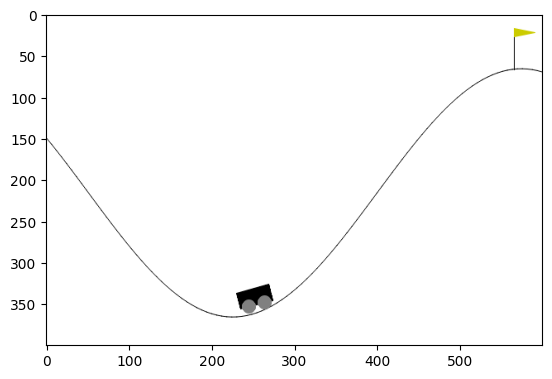

In [4]:
# Отрисовка
env = gym.make('MountainCar-v0', render_mode='rgb_array')
env.reset()
print(env.render().shape)
plt.imshow(env.render())

### Среда ``MountainCar-v0``

Информацию о любой среде можно найти в [исходниках](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/mountain_car.py) или на [сайте](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/). О ``MountainCar-v0`` мы можем узнать следующее: 

#### Задание:
Автомобиль едет по одномерному треку между двумя холмами. Цель состоит в том, чтобы заехать на правый холм; однако двигатель машины недостаточно мощный, чтобы взобраться на холм за один проход. Следовательно, единственный способ добиться успеха $-$ это двигаться вперед и назад, чтобы набрать обороты.

#### Пространство состояний Box(2):



Num | Observation  | Min  | Max  
----|--------------|------|----   
0   | position     | -1.2 | 0.6
1   | velocity     | -0.07| 0.07


#### Пространство действий Discrete(3):



Num | Action|
----|-------------|
0   | push left   |
1   | no push     |
2   | push right  |

- Вознаграждения: -1 за каждый шаг, пока не достигнута цель 

- Начальное состояние: Случайная позиция от -0.6 до -0.4 с нулевой скоростью.

### Пример со случайной стратегией:

Для выбора действия используется ``env.action_space.sample()``

In [5]:
from gymnasium.wrappers.record_video import RecordVideo

# создаем окружение с ограничением на число шагов в среде
env = gym.make("MountainCar-v0", render_mode="rgb_array", max_episode_steps=250)
# добавляем визуализацию
env = RecordVideo(env, "./video")

# проводим инициализацию и запоминаем начальное состояние
s, _ = env.reset()
done = False

while not done:
    # выполняем действие, получаем s, r, terminated, truncated, info
    s, r, terminated, truncated, _ = env.step(env.action_space.sample())
    done = terminated or truncated
    
env.close()

/Users/kuderov/mambaforge/envs/cleanrl/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /Users/kuderov/dev/courses/airi-summer-school-rl/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/kuderov/dev/courses/airi-summer-school-rl/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kuderov/dev/courses/airi-summer-school-rl/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kuderov/dev/courses/airi-summer-school-rl/video/rl-video-episode-0.mp4


In [6]:
from IPython.display import Video

def show_video(episode: int = 0):
    return display(Video(f'video/rl-video-episode-{episode}.mp4', embed=True))

show_video()

### Пример с handcrafted стратегией:
В среде MountainCar-v0 мы хотим, чтобы машина достигла флага. Давайте решим эту задачу, не используя обучение с подкреплением. Модифицируйте код функции ```act``` ниже для выполнения этого задания. Функция получает на вход состояние среды и должна вернуть действие.

In [7]:
def act(s):
    # список возможных действий
    left, stop, right = 0, 1, 2
    
    # позиция и скорость
    position, velocity = s
    # пример: можем попробовать всегда ехать вправо
    # action = right
    """<codehere>"""
    action = left if velocity < 0 else right
    """</codehere>"""
    return action

env = gym.make("MountainCar-v0", render_mode="rgb_array", max_episode_steps=250)
# добавляем визуализацию
env = RecordVideo(env, "./video")

# проводим инициализацию и запоминаем начальное состояние
s, _ = env.reset()
done = False

while not done:
    # выбор действия "агентом"
    action = act(s)
    
    # выполняем действие, получаем s, r, terminated, truncated, info
    s, r, terminated, truncated, _ = env.step(action)
    done = terminated or truncated


if s[0] > 0.47:
    print("Решено!")
else:
    print("Исправьте функцию выбора действия!")


env.close()
show_video()

/Users/kuderov/mambaforge/envs/cleanrl/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /Users/kuderov/dev/courses/airi-summer-school-rl/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/kuderov/dev/courses/airi-summer-school-rl/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kuderov/dev/courses/airi-summer-school-rl/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kuderov/dev/courses/airi-summer-school-rl/video/rl-video-episode-0.mp4
Решено!


## Part #2: DQN

В данном пункте реализуем алгоритм DQN для решения среды [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/), цель которой балансировать палочкой в вертикальном положении, управляя только тележкой, к которой она прикреплена.

![cartpole](https://gymnasium.farama.org/_images/cart_pole.gif)

![cartpole](https://www.researchgate.net/publication/362568623/figure/fig5/AS:1187029731807278@1660021350587/Screen-capture-of-the-OpenAI-Gym-CartPole-problem-with-annotations-showing-the-cart.png)

### Action Space

The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.

- 0: Push cart to the left
- 1: Push cart to the right

**Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle
the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

### Observation Space

The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation           | Min                 | Max               |
|-----|-----------------------|---------------------|-------------------|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

**Note:** While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:

- The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates if the cart leaves the `(-2.4, 2.4)` range.
- The pole angle can be observed between  `(-.418, .418)` radians (or **±24°**), but the episode terminates
   if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)

### Rewards

Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken,
including the termination step, is allotted. The threshold for rewards is 500 for v1 and 200 for v0.

### Starting State

All observations are assigned a uniformly random value in `(-0.05, 0.05)`

### Episode End

The episode ends if any one of the following occurs:

1. Termination: Pole Angle is greater than ±12°
2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
3. Truncation: Episode length is greater than 500 (200 for v0)

In [8]:
env = gym.make("CartPole-v1")
env.reset()

print(f'{env.observation_space=}')
print(f'{env.action_space=}')

n_actions = env.action_space.n
state_dim = env.observation_space.shape
print(f'Action_space: {n_actions} | State_space: {env.observation_space.shape}')

env.observation_space=Box([-4.800e+00 -3.403e+38 -4.189e-01 -3.403e+38], [4.800e+00 3.403e+38 4.189e-01 3.403e+38], (4,), float32)
env.action_space=Discrete(2)
Action_space: 2 | State_space: (4,)


Т.к. описание состояния в задаче с маятником представляет собой не "сырые" признаки, а уже предобработанные (координаты, углы), нам не нужна для начала сложная архитектура, начнем с такой:
<img src="https://raw.githubusercontent.com/Tviskaron/mipt/master/2020/RL/figures/DQN.svg">
Будем использовать только полносвязные слои (``torch.nn.Linear``) и простые активационные функции (``torch.nn.ReLU``).

Будем приближать Q-функцию агента, минимизируя среднеквадратичную TD-ошибку:
$$
\delta = Q_{\theta}(s, a) - [r(s, a) + \gamma \cdot max_{a'} Q_{-}(s', a')]
$$
$$
L = \frac{1}{N} \sum_i \delta_i^2,
$$
где
* $s, a, r, s'$ состояние, действие, вознаграждение и следующее состояние 
* $\gamma$ дисконтирующий множитель.

Основная тонкость состоит в использовании $Q_{-}(s',a')$. Это та же самая функция, что и $Q_{\theta}$, которая является выходом нейронной сети, но при обучении сети, мы не пропускаем через эти слои градиенты. В статьях можно обнаружить следующее обозначение для остановки градиента: $SG(\cdot)$.

In [10]:
import torch
import torch.nn as nn

def create_network(input_dim, hidden_dims, output_dim):
    # network = nn.Sequential(
    #    torch.nn.Linear(input_dim, ...),
    #    torch.nn.ReLU() or Tanh(),
    #    ...
    # )
    """<codehere>"""
    from_dim = input_dim
    layers = []
    for to_dim in hidden_dims:
        layers.extend([
            nn.Linear(from_dim, to_dim),
            nn.Tanh()
        ])
        from_dim = to_dim

    layers.append(nn.Linear(from_dim, output_dim))
    network = nn.Sequential(*layers)
    """</codehere>"""
    return network

In [11]:
def select_action_eps_greedy(Q, state, epsilon):
    """Выбирает действие epsilon-жадно."""
    if not isinstance(state, torch.Tensor):
        state = torch.tensor(state, dtype=torch.float32)
    Q_s = Q(state).detach().numpy()
    
    # action = 
    """<codehere>"""
    if np.random.random() < epsilon:
        n_actions = Q_s.shape[-1]
        action = np.random.choice(n_actions)
    else:
        action = np.argmax(Q_s)
    """</codehere>"""
    
    action = int(action)
    return action

In [12]:
def to_tensor(x, dtype=np.float32):
    if isinstance(x, torch.Tensor):
        return x
    x = np.asarray(x, dtype=dtype)
    x = torch.from_numpy(x)
    return x

def compute_td_loss(
        Q, states, actions, rewards, next_states, terminateds, 
        gamma=0.99, check_shapes=False, regularizer=.1
):
    """ Считает TD ошибку."""

    # переводим входные данные в тензоры
    s = to_tensor(states)                     # shape: [batch_size, state_size]
    a = to_tensor(actions, int).long()        # shape: [batch_size]
    r = to_tensor(rewards)                    # shape: [batch_size]
    s_next = to_tensor(next_states)           # shape: [batch_size, state_size]
    term = to_tensor(terminateds, bool)       # shape: [batch_size]

    # получаем Q[s, a] для выбранных действий в текущих состояниях (для каждого примера из батча)
    # Q_s_a = ...
    """<codehere>"""
    Q_s_a = torch.gather(Q(s), dim=1, index=torch.unsqueeze(a, 1)).squeeze(-1)
    """</codehere>"""

    # получаем Q[s_next, *] — значения полезности всех действий в следующих состояниях
    # Q_sn = ...,
    # а затем вычисляем V*[s_next] — оптимальные значения полезности следующих состояний
    # V_sn = ...
    """<codehere>"""
    with torch.no_grad():
        Q_sn = Q(s_next)
        V_sn, _ = torch.max(Q_sn, axis=-1)
    """</codehere>"""
    
    assert V_sn.dtype == torch.float32

    # вычисляем TD target и далее TD error
    # target = ...
    # td_error = ...
    """<codehere>"""
    target = r + gamma * V_sn * torch.logical_not(term)
    td_error = Q_s_a - target
    """</codehere>"""

    # MSE loss для минимизации
    loss = torch.mean(td_error ** 2)
    # добавляем регуляризацию на значения Q 
    loss += regularizer * Q_s_a.mean()
    
    if check_shapes:
        assert Q_sn.data.dim(
        ) == 2, "убедитесь, что вы предсказали q-значения для всех действий в следующем состоянии"
        assert V_sn.data.dim(
        ) == 1, "убедитесь, что вы вычислили V (s ') как максимум только по оси действий, а не по всем осям"
        assert target.data.dim(
        ) == 1, "что-то не так с целевыми q-значениями, они должны быть вектором"

    return loss

In [13]:
def eval_dqn(env_name, Q):
    """Оценка качества работы алгоритма на одном эпизоде"""
    env = gym.make(env_name)
    s, _ = env.reset()
    done, ep_return = False, 0.

    while not done:
        # set epsilon = 0 to make an agent act greedy
        a = select_action_eps_greedy(Q, s, epsilon=0.)
        s_next, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        ep_return += r
        s = s_next

        if done:
            break

    return ep_return

In [15]:
from collections import deque

def linear(st, end, duration, t):
    if t >= duration:
        return end
    return st + (end - st) * (t / duration)

def run_dqn(
        env_name="CartPole-v1", 
        hidden_dims=(128, 128), lr=1e-3, 
        eps_st=.4, eps_end=.02, eps_dur=.5, total_max_steps=100_000,
        train_schedule=1, eval_schedule=1000, smooth_ret_window=5, success_ret=200.
):
    env = gym.make(env_name)
    eval_return_history = deque(maxlen=smooth_ret_window)
    
    Q = create_network(
        input_dim=env.observation_space.shape[0], hidden_dims=hidden_dims, output_dim=env.action_space.n
    )
    opt = torch.optim.Adam(Q.parameters(), lr=lr)
    
    s, _ = env.reset()
    done = False

    for global_step in range(1, total_max_steps+1):
        epsilon = linear(eps_st, eps_end, eps_dur * total_max_steps, global_step)
        
        a = select_action_eps_greedy(Q, s, epsilon=epsilon)
        s_next, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        
        if global_step % train_schedule == 0:
            opt.zero_grad()
            loss = compute_td_loss(Q, [s], [a], [r], [s_next], [terminated])
            loss.backward()
            opt.step()
        
        if global_step % eval_schedule == 0:
            eval_return = eval_dqn(env_name, Q)
            eval_return_history.append(eval_return)
            avg_return = np.mean(eval_return_history)
            print(f'{global_step=} | {avg_return=:.3f} | {epsilon=:.3f}')
            if avg_return >= success_ret:
                print('Решено!')
                break

        s = s_next
        if done:
            s, _ = env.reset()
            done = False

run_dqn()

global_step=1000 | avg_return=21.000 | epsilon=0.392
global_step=2000 | avg_return=72.000 | epsilon=0.385
global_step=3000 | avg_return=114.333 | epsilon=0.377
global_step=4000 | avg_return=124.500 | epsilon=0.370
global_step=5000 | avg_return=140.400 | epsilon=0.362
global_step=6000 | avg_return=174.600 | epsilon=0.354
global_step=7000 | avg_return=250.000 | epsilon=0.347
Решено!


### DQN with Experience Replay

Теперь попробуем добавить поддержку памяти прецедентов (Replay Buffer), которая будет из себя представлять очередь из наборов: $\{(s, a, r, s', 1_\text{terminated})\}$.

Тогда во время обучения каждый новый переход будет добавляться в память, а обучение будет целиком производиться на переходах, просэмплированных из памяти прецедентов.

In [16]:
def sample_batch(replay_buffer, n_samples):
    # sample randomly `n_samples` samples from replay buffer
    # and split an array of samples into arrays: states, actions, rewards, next_actions, terminateds
    """<codehere>"""
    n_samples = min(len(replay_buffer), n_samples)

    indices = np.random.choice(len(replay_buffer), n_samples, replace=False)
    states, actions, rewards, next_actions, terminateds = [], [], [], [], []
    for i in indices:
        s, a, r, n_s, done = replay_buffer[i]
        states.append(s)
        actions.append(a)
        rewards.append(r)
        next_actions.append(n_s)
        terminateds.append(done)
    """</codehere>"""
        
    return np.array(states), np.array(actions), np.array(rewards), np.array(next_actions), np.array(terminateds)

In [17]:
def run_dqn_rb(
        env_name="CartPole-v1", 
        hidden_dims=(256, 256), lr=2e-3,
        eps_st=.4, eps_end=.02, eps_dur=.5, total_max_steps=200_000,
        train_schedule=4, replay_buffer_size=400, batch_size=32,
        eval_schedule=1000, smooth_ret_window=5, success_ret=200.
):
    env = gym.make(env_name)
    replay_buffer = deque(maxlen=replay_buffer_size)
    eval_return_history = deque(maxlen=smooth_ret_window)
    
    Q = create_network(
        input_dim=env.observation_space.shape[0], hidden_dims=hidden_dims, output_dim=env.action_space.n
    )
    opt = torch.optim.Adam(Q.parameters(), lr=lr)
    
    s, _ = env.reset()
    done = False

    for global_step in range(1, total_max_steps+1):
        epsilon = linear(eps_st, eps_end, eps_dur * total_max_steps, global_step)
        a = select_action_eps_greedy(Q, s, epsilon=epsilon)
        s_next, r, terminated, truncated, _ = env.step(a)

        replay_buffer.append((s, a, r, s_next, terminated))
        done = terminated or truncated
        
        if global_step % train_schedule == 0:
            train_batch = sample_batch(replay_buffer, batch_size)
            states, actions, rewards, next_states, terminateds = train_batch
            
            opt.zero_grad()
            loss = compute_td_loss(Q, states, actions, rewards, next_states, terminateds)
            loss.backward()
            opt.step()
        
        if global_step % eval_schedule == 0:
            eval_return = eval_dqn(env_name, Q)
            eval_return_history.append(eval_return)
            avg_return = np.mean(eval_return_history)
            print(f'{global_step=} | {avg_return=:.3f} | {epsilon=:.3f}')
            if avg_return >= success_ret:
                print('Решено!')
                break

        s = s_next
        if done:
            s, _ = env.reset()
            done = False

run_dqn_rb()

global_step=1000 | avg_return=133.000 | epsilon=0.396
global_step=2000 | avg_return=126.500 | epsilon=0.392
global_step=3000 | avg_return=145.000 | epsilon=0.389
global_step=4000 | avg_return=132.250 | epsilon=0.385
global_step=5000 | avg_return=137.800 | epsilon=0.381
global_step=6000 | avg_return=179.400 | epsilon=0.377
global_step=7000 | avg_return=255.400 | epsilon=0.373
Решено!


## Part #3: Actor-Critic

Теорема о градиенте стратегии связывает градиент целевой функции  и градиент самой стратегии:

$$\nabla_\theta J(\theta) = \mathbb{E}_\pi [Q^\pi(s, a) \nabla_\theta \ln \pi_\theta(a \vert s)]$$

Встает вопрос, как оценить $Q^\pi(s, a)$? В чистом policy-based алгоритме REINFORCE используется отдача $R_t$, полученная методом Монте-Карло в качестве несмещенной оценки $Q^\pi(s, a)$. В Actor-Critic же предлагается отдельно обучать нейронную сеть Q-функции — критика.

Актор-критиком часто называют обобщенный фреймворк (подход), нежели какой-то конкретный алгоритм. Как подход актор-критик не указывает, каким конкретно [policy gradient] методом обучается актор и каким [value based] методом обучается критик. Таким образом актор-критик задает целое [семейство](https://proceedings.neurips.cc/paper_files/paper/1999/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) различных алгоритмов.

Сейчас познакомимся с наиболее простым вариантом:

In [18]:
import torch
import torch.nn as nn
from torch.distributions import Categorical

class ActorBatch:
    def __init__(self):
        self.logprobs = []
        self.q_values = []
        
    def append(self, log_prob, q_value):
        self.logprobs.append(log_prob)
        self.q_values.append(q_value)
    
    def clear(self):
        self.logprobs.clear()
        self.q_values.clear()

    
class ActorCriticModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()

        # Инициализируйте сеть агента с двумя головами: softmax-актора и линейного критика
        # self.net, self.actor_head, self.critic_head =
        """<codehere>"""
        from_dim = input_dim
        layers = []
        for to_dim in hidden_dims:
            layers.extend([
                nn.Linear(from_dim, to_dim),
                nn.Tanh()
            ])
            from_dim = to_dim
        
        self.net = nn.Sequential(*layers)
        self.actor_head = nn.Sequential(
            nn.Linear(hidden_dims[-1], output_dim),
            nn.Softmax(dim=-1)
        )
        self.critic_head = nn.Sequential(
            nn.Linear(hidden_dims[-1], output_dim),
        )
        # self.actor_head = nn.Sequential(
        #     create_network(input_dim, hidden_dims, output_dim),
        #     nn.Softmax(dim=-1)
        # )
        # self.critic_head = create_network(input_dim, hidden_dims, output_dim)
        """</codehere>"""
        
    def forward(self, state):
        # Вычислите выбранное действие, логарифм вероятности его выбора и соответствующее значение Q-функции
        """<codehere>"""
        state = self.net(state)
        
        action_probs = self.actor_head(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        q_values = self.critic_head(state)
        
        log_prob = dist.log_prob(action)
        action = action.item()
        # adv = q_values[action] - torch.sum(q_values * action_probs, -1)
        q_value = q_values[action]
        """</codehere>"""
        
        return action, log_prob, q_value
    
    def evaluate(self, state):
        # Вычислите значения Q-функции для данного состояния
        """<codehere>"""
        state = self.net(state)
        
        q_values = self.critic_head(state)
        """</codehere>"""
        return q_values


class ActorCriticAgent:
    def __init__(self, state_dim, action_dim, hidden_dims, lr, gamma, critic_rb_size):
        self.lr = lr
        self.gamma = gamma

        # Инициализируйте модель актор-критика и SGD оптимизатор (например, `torch.optim.Adam)`)
        """<codehere>"""
        self.actor_critic = ActorCriticModel(state_dim, hidden_dims, action_dim)
        self.actor_opt = self.critic_opt = self.opt = torch.optim.Adam(self.actor_critic.parameters(), lr=lr)
        # self.actor_opt = torch.optim.Adam(self.actor_critic.actor_head.parameters(), lr=lr)
        # self.critic_opt = torch.optim.Adam(self.actor_critic.critic_head.parameters(), lr=lr*.25)
        """</codehere>"""

        self.actor_batch = ActorBatch()
        self.critic_rb = deque(maxlen=critic_rb_size)
        
    def act(self, state):
        # Произведите выбор действия и сохраните необходимые данные в батч для последующего обучения
        # Не забудьте сделать q_value.detach()
        # self.actor_batch.append(..)
        """<codehere>"""
        action, logprob, q_value = self.actor_critic(to_tensor(state))
        self.actor_batch.append(logprob, q_value.detach())

        # action = select_action_eps_greedy(self.actor_critic.critic_head, state, 0.05)
        """</codehere>"""
        
        return action
        
    def append_to_replay_buffer(self, s, a, r, next_s, terminated):
        # Добавьте новый экземпляр данных в память прецедентов.
        """<codehere>"""
        self.critic_rb.append((s, a, r, next_s, terminated))
        """</codehere>"""
    
    def evaluate(self, state):
        return self.actor_critic.evaluate(state)
    
    def update(self, rollout_size, critic_batch_size, critic_updates_per_actor):
        if len(self.actor_batch.q_values) < rollout_size:
            return

        self.update_actor()
        self.update_critic(critic_batch_size, critic_updates_per_actor)

    def update_actor(self):
        Q_s_a = to_tensor(self.actor_batch.q_values)
        logprobs = torch.stack(self.actor_batch.logprobs)

        # Реализуйте шаг обновления актора — вычислите ошибку `loss` и произведите шаг обновления градиентным спуском. 
        # Опционально: сделайте нормализацию отдач
        """<codehere>"""
        # Нормализация отдач
        Q_s_a = (Q_s_a - Q_s_a.mean()) / (Q_s_a.std() + 1e-7)

        # Считаем ошибку
        loss = -torch.mean(Q_s_a * logprobs)
        
        self.actor_opt.zero_grad()
        loss.backward()
        self.actor_opt.step()
        self.actor_batch.clear()
        """</codehere>"""
    
    def update_critic(self, batch_size, n_updates=1):
        # Реализуйте n_updates шагов обучения критика.
        """<codehere>"""

        if len(self.critic_rb) < batch_size:
            return

        for _ in range(n_updates):
            train_batch = sample_batch(self.critic_rb, batch_size)
            states, actions, rewards, next_states, terminateds = train_batch
            
            self.critic_opt.zero_grad()
            loss = self.compute_td_loss(states, actions, rewards, next_states, terminateds)
            loss.backward()
            self.critic_opt.step()
        """</codehere>"""
        
    def compute_td_loss(
        self, states, actions, rewards, next_states, terminateds, regularizer=.1
    ):
        # переводим входные данные в тензоры
        s = to_tensor(states)                     # shape: [batch_size, state_size]
        a = to_tensor(actions, int).long()        # shape: [batch_size]
        r = to_tensor(rewards)                    # shape: [batch_size]
        s_next = to_tensor(next_states)           # shape: [batch_size, state_size]
        term = to_tensor(terminateds, bool)       # shape: [batch_size]

        
        # получаем Q[s, a] для выбранных действий в текущих состояниях (для каждого примера из батча)
        # Q_s_a = ...
        """<codehere>"""
        Q_s_a = torch.gather(
            self.evaluate(s), dim=1, index=torch.unsqueeze(a, 1)
        ).squeeze(1)
        """</codehere>"""
    
        # получаем Q[s_next, *] — значения полезности всех действий в следующих состояниях
        # Q_sn = ...,
        # а затем вычисляем V*[s_next] — оптимальные значения полезности следующих состояний
        # V_sn = ...
        """<codehere>"""
        with torch.no_grad():
            Q_sn = self.evaluate(s_next)
            V_sn, _ = torch.max(Q_sn, axis=-1)
        """</codehere>"""
    
        # вычисляем TD target и далее TD error
        # target = ...
        # td_error = ...
        """<codehere>"""
        target = r + self.gamma * V_sn * torch.logical_not(term)
        td_error = Q_s_a - target
        """</codehere>"""
    
        # MSE loss для минимизации
        loss = torch.mean(td_error ** 2)
        # добавляем регуляризацию на значения Q 
        loss += regularizer * Q_s_a.mean()
        return loss

def run_actor_critic(
        env_name="CartPole-v1", 
        hidden_dims=(128, 128), lr=1e-3,
        total_max_steps=200_000,
        # train_schedule=4, replay_buffer_size=4, batch_size=4, critic_updates_per_actor=1,
        train_schedule=32, replay_buffer_size=5000, batch_size=32, critic_updates_per_actor=4,
        eval_schedule=1000, smooth_ret_window=5, success_ret=200.
):
    env = gym.make(env_name)
    episode_return_history = deque(maxlen=smooth_ret_window)

    agent = ActorCriticAgent(
        state_dim=env.observation_space.shape[0], action_dim=env.action_space.n, hidden_dims=hidden_dims,
        lr=lr, gamma=.995, critic_rb_size=replay_buffer_size
    )
    
    s, _ = env.reset()
    done, episode_return = False, 0.
    eval = False

    for global_step in range(1, total_max_steps+1):
        a = agent.act(s)
        s_next, r, terminated, truncated, _ = env.step(a)
        episode_return += r
        done = terminated or truncated

        # train step
        agent.append_to_replay_buffer(s, a, r, s_next, terminated)
        agent.update(train_schedule, batch_size, critic_updates_per_actor)

        # evaluate
        if global_step % eval_schedule == 0:
            eval = True

        s = s_next
        if done:
            if eval:
                episode_return_history.append(episode_return)
                avg_return = np.mean(episode_return_history)
                print(f'{global_step=} | {avg_return=:.3f}')
                if avg_return >= success_ret:
                    print('Решено!')
                    break

            s, _ = env.reset()
            done, episode_return = False, 0.
            eval = False

run_actor_critic()

global_step=1009 | avg_return=11.000
global_step=2005 | avg_return=13.500
global_step=3003 | avg_return=17.333
global_step=4006 | avg_return=26.000
global_step=5008 | avg_return=23.400
global_step=6074 | avg_return=39.800
global_step=7047 | avg_return=68.400
global_step=8073 | avg_return=79.200
global_step=9040 | avg_return=89.600
global_step=10069 | avg_return=121.800
global_step=11031 | avg_return=128.000
global_step=12216 | avg_return=164.400
global_step=13045 | avg_return=169.400
global_step=14099 | avg_return=173.000
global_step=15081 | avg_return=157.600
global_step=16078 | avg_return=155.800
global_step=17020 | avg_return=110.400
global_step=18066 | avg_return=111.600
global_step=19084 | avg_return=115.000
global_step=20017 | avg_return=117.000
global_step=21115 | avg_return=127.800
global_step=22113 | avg_return=129.000
global_step=23021 | avg_return=124.400
global_step=24099 | avg_return=117.600
global_step=25076 | avg_return=120.600
global_step=26003 | avg_return=89.000
globa

In [18]:
"""<comment>"""
from codehere import convert
import os

os.makedirs('render', exist_ok=True)

nb_name = '01.gym_dqn_ac'
convert(
    file=f'{nb_name}.ipynb',
    outfile=f'render/{nb_name}.ipynb',
    clear=True, replacement=" Здесь ваш код "
)
convert(
    file=f'{nb_name}.ipynb',
    outfile=f'render/{nb_name}-solution.ipynb',
    clear=True, solution=True, replacement=" Здесь ваш код "
)
"""</comment>"""

Saved in:  render/01.gym_dqn_ac.ipynb
Saved in:  render/01.gym_dqn_ac-solution.ipynb


'</comment>'